# Initilalizing

In [2]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [3]:
%cd /gdrive/MyDrive/
%ls

/gdrive/MyDrive
'Colab Notebooks'/                       IncpetionModel1/
 Dataset/                                model_plot.png
 FinalModel/                             model.png
 Gabriele/                               S3CRET/
 IncpetionFtAugModel1/                   SimpleLSTMForecasting/
 IncpetionFtAugWeighModel1/              SimplerModel/
 IncpetionFtAugWeighModel1_more_layer/   StandardModel/
 IncpetionFtModel1/                      training/


In [4]:
import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt
plt.rc('font', size=16)
from sklearn.preprocessing import MinMaxScaler
import warnings
import math
warnings.filterwarnings('ignore')
tf.get_logger().setLevel('ERROR')

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

2.7.0


In [5]:
# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

### Load the dataset

In [6]:
dataset = pd.read_csv('Dataset/Training.csv')
print(dataset.shape)
dataset.head()

(68528, 7)


,Sponginess,Wonder level,Crunchiness,Loudness on impact,Meme creativity,Soap slipperiness,Hype root
0,7.97698,4.33494,10.67282,1.76692,3.22440,51.681460,3.65434
1,8.07824,4.44616,10.56160,1.70716,3.32566,51.563598,3.47672
2,8.02844,4.22372,10.56160,1.64906,3.17460,50.863080,3.47672
3,8.02844,4.22372,10.56160,1.70716,3.17460,45.841581,3.47672
4,7.87572,4.44616,10.45038,1.70716,3.27586,47.126421,3.47672


In [7]:
# Normalize both features and labels
X_min = dataset.min()
X_max = dataset.max()

print(X_min)
print(X_max)

Sponginess            -0.972080
Wonder level          -8.450380
Crunchiness          -37.581721
Loudness on impact    -9.028060
Meme creativity       -1.275860
Soap slipperiness     -6.006860
Hype root            -42.769221
dtype: float64
Sponginess            15.106680
Wonder level          18.122899
Crunchiness           41.138801
Loudness on impact    14.035980
Meme creativity        6.056360
Soap slipperiness     77.371620
Hype root             31.024420
dtype: float64


In [8]:
dataset_norm = (dataset-X_min)/((X_max-X_min))
dataset_norm.head()

,Sponginess,Wonder level,Crunchiness,Loudness on impact,Meme creativity,Soap slipperiness,Hype root
0,0.556576,0.481134,0.612986,0.468044,0.613765,0.691885,0.629100
1,0.562874,0.485320,0.611573,0.465453,0.627575,0.690471,0.626693
2,0.559777,0.476949,0.611573,0.462934,0.606973,0.682070,0.626693
3,0.559777,0.476949,0.611573,0.465453,0.606973,0.621844,0.626693
4,0.550279,0.485320,0.610160,0.465453,0.620783,0.637254,0.626693


In [9]:
target_labels = dataset_norm.columns

In [10]:
TELESCOPE = 864
WINDOWS_LENGTH = 200
VALIDATION_SPLIT = 0.2
FEATURES = dataset.shape[1]

In [11]:
X_val = dataset_norm[-TELESCOPE:]
#y_train = dataset_norm[]
X_train = dataset_norm[0:dataset_norm.shape[0]-TELESCOPE ]
#y_val = dataset_norm[]
X_train.shape, X_val.shape

((67664, 7), (864, 7))

In [12]:
STEPS = dataset.shape[0] #X_train.shape[0]-1 

In [81]:
inputs = tfkl.Input(shape=(None, FEATURES), batch_size=1)
outputs = tfkl.LSTM(units=256, 
               stateful=True, 
               return_sequences=True, 
               input_shape=(None,FEATURES))(inputs)
outputs = tfkl.LSTM(units=128, 
               stateful=True, 
               return_sequences=True, 
               input_shape=(None,FEATURES))(outputs)
outputs = tfkl.LSTM(units=FEATURES, 
               stateful=True, 
               return_sequences=True, 
               input_shape=(None,FEATURES))(outputs) 
    #units = features because we want to use the outputs as inputs
    #None because we want variable length
#outputs = tfkl.Dense(units=32)(outputs)
outputs = tfkl.Dense(units=FEATURES)(outputs)  

#output_shape -> (batch_size, steps, units)
model = tfk.Model(inputs=inputs, outputs=outputs)
# summarize layers
print(model.summary())
model.compile(loss=tf.losses.MeanSquaredError(),
                      metrics=[tf.keras.metrics.RootMeanSquaredError()])
#output_shape -> (batch_size, steps, units)

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(1, None, 7)]            0         
                                                                 
 lstm_21 (LSTM)              (1, None, 256)            270336    
                                                                 
 lstm_22 (LSTM)              (1, None, 128)            197120    
                                                                 
 lstm_23 (LSTM)              (1, None, 7)              3808      
                                                                 
 dense_10 (Dense)            (1, None, 7)              56        
                                                                 
Total params: 471,320
Trainable params: 471,320
Non-trainable params: 0
_________________________________________________________________
None


In [84]:
totalSequences = np.array(dataset_norm) #X_train
totalSequences = np.expand_dims(totalSequences, axis=0)
totalSequences.shape

    #batch size is usually 1 in these cases (often you have only one Tank in the example)

X = totalSequences[:,:-1,:] #the entire known sequence, except the last step
#X = X_train
X.shape
Y = totalSequences[:,1:,:] #one step ahead of X
#Y = y_train
Y.shape
#loop for resetting states at the start/end of the sequences:
epochs = 10
for epoch in range(epochs):
    model.reset_states()
    model.train_on_batch(X,Y )
    print(epoch)

0
1
2
3
4
5
6
7
8
9


In [85]:
model.reset_states() #starting a new sequence
predicted = model.predict(X)
firstNewStep = predicted[:,-1:,:] #the last step of the predictions is the first future step

In [86]:
firstNewStep.shape, predicted.shape, np.array(predicted).shape

((1, 1, 7), (1, 68527, 7), (1, 68527, 7))

In [87]:
output_sequence = [firstNewStep]
last_step = firstNewStep
for i in range(TELESCOPE):
    new_step = model.predict(last_step)
    output_sequence.append(new_step)
    last_step = new_step

 #end of the sequences
model.reset_states()

In [88]:
np.array(output_sequence).shape

(865, 1, 1, 7)

In [89]:
fut = np.reshape(np.array(output_sequence), newshape=(865,7))
pred = np.reshape(np.array(predicted), newshape=(68527,7))
X1 = np.reshape(X, newshape=(68527,7))

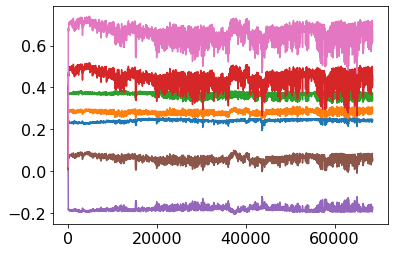

In [90]:
plt.plot(pred)

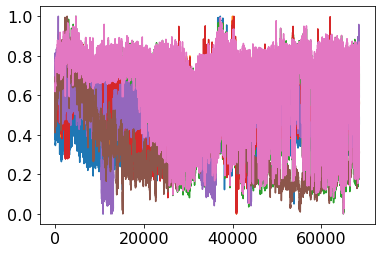

In [91]:
plt.plot(X1)

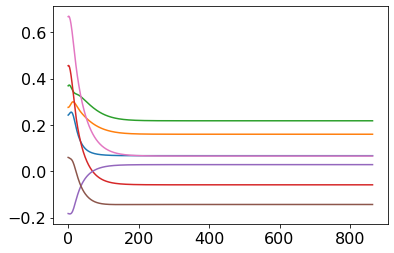

In [92]:
plt.plot(fut)